Rafa Martinez-Avial Palazuelos


# Predicting the price of a stock with a neural network

##Introduction
In this project, I will be implementing a neural network in TensorFlow. The purpose of the neural network is to predict the price of a stock given time series data on its historical price. In particular, I will make the arbitrary choice to make it predict the price of the stock on a given day given the previous 60 days. In writing the following code, I found TensorFlow Core's tutorials on Keras and especially the Medium article "Predicting stock prices using deep learning" and the associated GitHub repository particularly helpful. A lot of the code and, in particular, the choice of layers of the neural network are borrowed from there (https://github.com/yacoubb/stock-trading-ml). 

##The dataset
Apple is currently doing pretty well on the stock market. In fact, it's doing better than every other company ever. As a consequence, I wanted my neural network to study it. I downloaded a .csv file from Yahoo Finance that contained information about Apple's stock price from every day since its IPO in 1980: the opening price, daily high, daily low, closing price and volume of stocks traded in that day. The .csv file also contained a column for the day in question as well as a slight modification to the closing price. I, however, decided to eliminate these two variables from the dataframe that I  used to train my neural network. The following code contains the definition of a function which will read the .csv file containing the time series of the stock of interest, extract the relevant information and present it in a normalized format (between 0 and 1).

In [ ]:
import pandas as pd
from sklearn import preprocessing
import numpy as np

history_points = 60 #Number of days the neural network will use to predict the openining price of the next day

def csv_to_dataset(csv_path):
    data = pd.read_csv(csv_path)
    data = data.drop('Date', axis=1)
    data = data.drop('Adj Close', axis=1)
    data = data.drop(0, axis=0)

    data=data.values
    data_normaliser = preprocessing.MinMaxScaler()
    data_normalised = data_normaliser.fit_transform(data)
    # using the last {history_points} open high low close volume data points, predict the next open value
    ohlcv_histories_normalised =      np.array([data_normalised[i  : i + history_points].copy() for i in range(len(data_normalised) - history_points)])
    next_day_open_values_normalised = np.array([data_normalised[:,0][i + history_points].copy() for i in range(len(data_normalised) - history_points)])
    next_day_open_values_normalised = np.expand_dims(next_day_open_values_normalised, -1)
    next_day_open_values = np.array([data[:, 0][i + history_points].copy() for i in range(len(data) - history_points)])
    next_day_open_values = np.expand_dims(next_day_open_values, -1)
    y_normaliser = preprocessing.MinMaxScaler()
    y_normaliser.fit(next_day_open_values)
    assert ohlcv_histories_normalised.shape[0] == next_day_open_values_normalised.shape[0]
    return ohlcv_histories_normalised, next_day_open_values_normalised, next_day_open_values, y_normaliser


The objects outputted by the function above are:

*   An array whose entries represent the price of the stock for the 60 days preceeding each of the days of the time series, but normalized.
*   An array representing the opening price of the stock for each of the day in the time series, again normalized.
*   An array containing the unnormalized open day values.
*   A function which will rescale data according to the particular scale of the previous array.



Now I will apply the function to the Apple .csv file (named 'AAPL.csv') and split it up into a training set and a testing set.

In [ ]:
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation
from keras import optimizers
import numpy as np
np.random.seed(4)

ohlcv_histories, next_day_open_values, unscaled_y, y_normaliser=csv_to_dataset('AAPL.csv')
test_split = 0.9
n = int(ohlcv_histories.shape[0] * test_split) #Size of the training set given corresponding to the specified ratio given the size of the data

ohlcv_train = ohlcv_histories[:n]
y_train = next_day_open_values[:n]

ohlcv_test = ohlcv_histories[n:]
y_test = next_day_open_values[n:]

unscaled_y_test = unscaled_y[n:]

print(ohlcv_train.shape)
print(ohlcv_test.shape)





(9018, 60, 5)
(1002, 60, 5)


We see that the arrays representing the training and testing sets have identical formats yet different lengths, just as desired. Now we're ready to build the actual neural network.

## The model
The choice of neural network that I made is the simplest one that worked for Yacoub Ahmed's implementation. It contains:

* A layer of 50 Long Short Term Memory cells (LSTMs). These are like small neural networks with the characteristic that they hold a memory of their previous state. This is particularly useful in the statistical analysis of non-Markovian time series.
* A dropout layer which introduces artificial noise to prevent overfitting
* A few dense layers, which are the normal type of layer in a neural network. They simply find patterns in the previous layer and try to feed them into the next one.
* Two activation layers. The first one undoes the normalizing of the data stored up until it via a sigmoid function. The second one is a linear activation, so it amplifies linearly the output of the last dense layer.

In [ ]:
# model architecture
lstm_input = Input(shape=(history_points, 5), name='lstm_input')
x = LSTM(50, name='lstm_0')(lstm_input)
x = Dropout(0.2, name='lstm_dropout_0')(x)
x = Dense(64, name='dense_0')(x)
x = Activation('sigmoid', name='sigmoid_0')(x)
x = Dense(1, name='dense_1')(x)
output = Activation('linear', name='linear_output')(x)
model = Model(inputs=lstm_input, outputs=output)

When I first ran this neural network on my Apple data, I kept getting NaN values for the loss function. This frustrated me for a long time until I realized that the data I was feeding into its training also contained NaN. The following lines converts those entries into zeroes.

In [ ]:
ohlcv_train=np.nan_to_num(ohlcv_train)
y_train=np.nan_to_num(y_train)

The following lines of code train the model created above to fit the training data as well as possible. It does so by means of 50 epochs of stochastic gradient descent, which you can read more about in Siddharth's final project!

In [ ]:
adam = optimizers.Adam(lr=0.0005)
model.compile(optimizer=adam, loss='mse')
model.fit(x=ohlcv_train,y=y_train, batch_size=32, epochs=50, shuffle=True, validation_split=0.1)
evaluation = model.evaluate(ohlcv_test, y_test)
print(evaluation)

Epoch 1/50
254/254 [==============================] - 7s 27ms/step - loss: 0.0133 - val_loss: 1.8289e-04
Epoch 2/50
254/254 [==============================] - 6s 25ms/step - loss: 7.9395e-05 - val_loss: 1.1772e-04
Epoch 3/50
254/254 [==============================] - 7s 26ms/step - loss: 4.8248e-05 - val_loss: 5.8115e-05
Epoch 4/50
254/254 [==============================] - 7s 26ms/step - loss: 3.3651e-05 - val_loss: 1.2189e-04
Epoch 5/50
254/254 [==============================] - 7s 26ms/step - loss: 2.6010e-05 - val_loss: 4.1163e-05
Epoch 6/50
254/254 [==============================] - 7s 26ms/step - loss: 2.1261e-05 - val_loss: 3.2362e-05
Epoch 7/50
254/254 [==============================] - 7s 26ms/step - loss: 1.8683e-05 - val_loss: 3.2163e-05
Epoch 8/50
254/254 [==============================] - 7s 27ms/step - loss: 1.5433e-05 - val_loss: 3.2599e-05
Epoch 9/50
254/254 [==============================] - 7s 27ms/step - loss: 1.3379e-05 - val_loss: 5.7446e-05
Epoch 10/50
254/254 [==

The number outputted at the very end is the final mean squared error of our predictions. It seems very low, but it refers to the normalized data. In order to put intuitive bounds on it, we need to undo this normalization and find the scaled MSE instead.

In [ ]:


y_test_predicted = model.predict(ohlcv_test)
y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)
y_predicted = model.predict(ohlcv_histories)
y_predicted = y_normaliser.inverse_transform(y_predicted)

assert unscaled_y_test.shape == y_test_predicted.shape
real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
print(scaled_mse)


26.87435648849873


We see that, on average, the value of the stock predicted by the neural network is approximately 5.18 dollars off from the market value. Not too shabby!

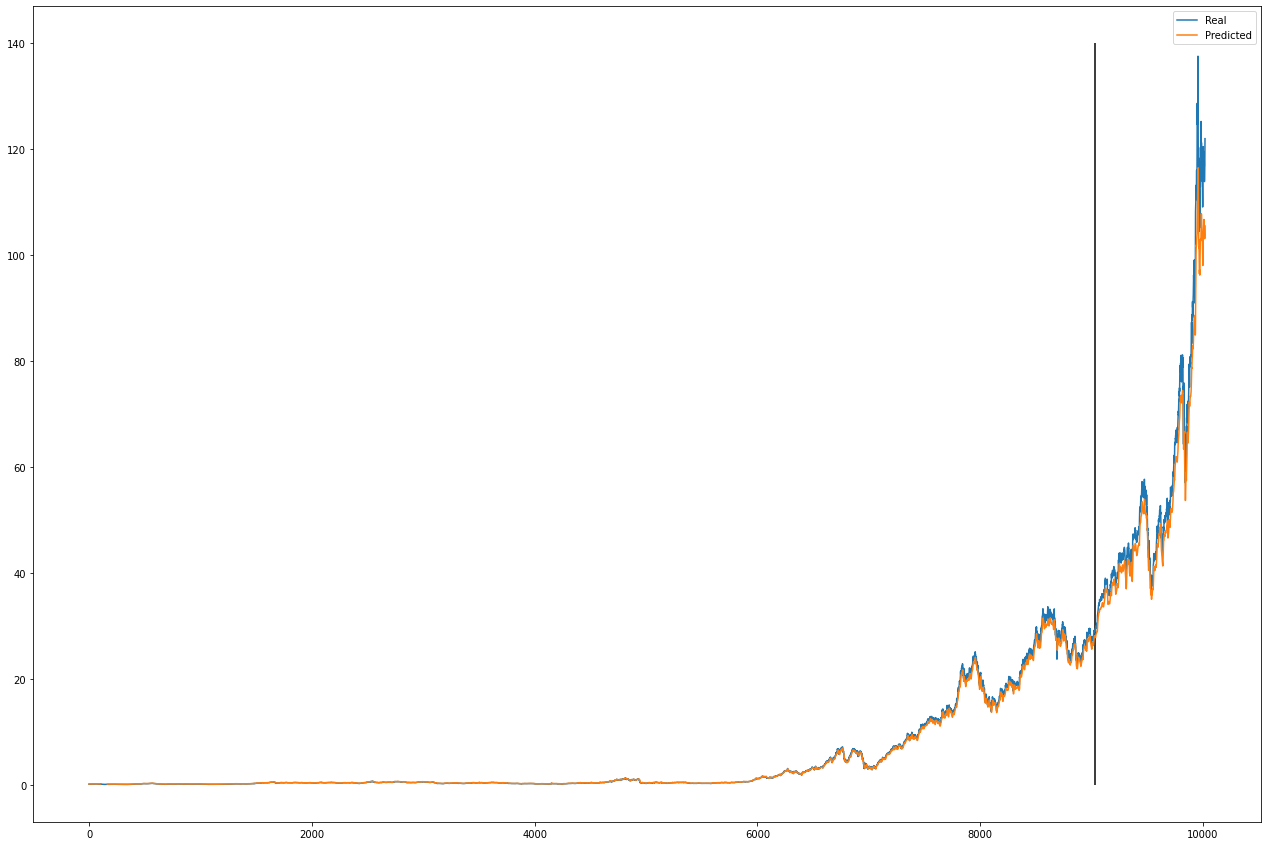

In [ ]:
import matplotlib.pyplot as plt

plt.gcf().set_size_inches(22, 15, forward=True)

start = 0
end = -1

#real = plt.plot(unscaled_y_test[start:end], label='real')
#pred = plt.plot(y_test_predicted[start:end], label='predicted')

real = plt.plot(unscaled_y[start:end], label='real')
pred = plt.plot(y_predicted[start:end], label='predicted')
plt.vlines(9027, 0, 140)
       
plt.legend(['Real', 'Predicted'])

plt.show()

## Conclusion
As seen in the graph above, our neural network did at least a decent job at predicting the price of the stock. The vertical line separates the training set from the testing set. As expected, the neural network had a better overall performance in the training set but its performance in the testing set was still pretty good. Due to the inherently unpredictable and erratic nature of stock prices, I wasn't expecting anything better.

I have now shown that Deep Learning can be a fairly effective tool in financial modeling. This is probably partially due to the fact that deep learning is effective at picking up underlying patterns that can't be modeled through theory, as is the case with the irrational behavior and unpredictable phenomena that has such a high impact on the value of a stock's price. In the process of demonstrating this, I've gotten to learn TensorFlow as well as Numpy and Pandas!